In [37]:
"""
This notebook provides a demo overview of the forward stagewise additive modeling approach to building a TBFM.
"""

%load_ext autoreload
%autoreload 2

import random
import time

import matplotlib.pyplot as plt
import torch
from torch import nn

from tbfm import tbfm_additive
from tbfm import test

BATCH_SIZE = 2500
RUNWAY_LENGTH = 20
TRIAL_LENGTH = 184
NUM_CHANNELS = 3
TRAIN_SET_SIZE = 1750

DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# This generates some demo data using an Ornstein-Uhlenbeck process
# OUPs have been used to model various neuron-level phenomena such as synaptic inputs and firing rates, making
data = torch.zeros(BATCH_SIZE, TRIAL_LENGTH, NUM_CHANNELS).to(DEVICE)
for cidx in range(NUM_CHANNELS):
    channel_data = test.generate_ou_sinusoidal_moving_mean(
        trial_len=TRIAL_LENGTH,
        batch_size=BATCH_SIZE,
        phase_shift=15*cidx,
        wavelength=80,
        sigma=0.2,        # Noise variance of the process. Raise this to make the process more stochastic.
    ).squeeze()
    data[:, :, cidx] = channel_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


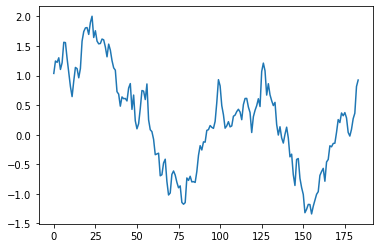

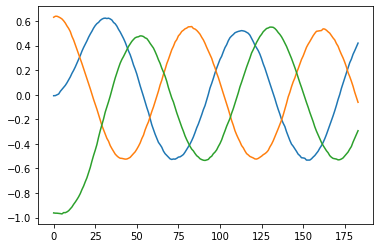

In [38]:
# This is what a single channel, single trial looks like
plt.plot(data[0, :, 0].to("cpu"))
plt.show()

# And some channel means across all trials
plt.plot(torch.mean(data[:, :, 0], axis=0).to("cpu"))
plt.plot(torch.mean(data[:, :, 1], axis=0).to("cpu"))
plt.plot(torch.mean(data[:, :, 2], axis=0).to("cpu"))
plt.show()

In [39]:
# Now we chunk the data up into the runway (x) versus predicted portion (y)
runways = data[:, :RUNWAY_LENGTH, :]
y = data[:, RUNWAY_LENGTH:, :]

# Then make a train versus test set
runways_train = runways[:TRAIN_SET_SIZE, :, :]
y_train = y[:TRAIN_SET_SIZE, :, :]
runways_test = runways[TRAIN_SET_SIZE:, :, :]
y_test = y[TRAIN_SET_SIZE:, :, :]

# We aren't stimulating, so let's make some null stimulation descriptors
STIM_DESC_DIM = 3
stim_desc = torch.zeros(1, TRIAL_LENGTH, STIM_DESC_DIM)
stim_desc[0, :, 0] = torch.arange(TRIAL_LENGTH) / TRIAL_LENGTH
stim_desc = stim_desc[:, RUNWAY_LENGTH:, :].to(DEVICE)

stim_desc_train = stim_desc.repeat(runways_train.shape[0], 1, 1)
stim_desc_test = stim_desc.repeat(runways_test.shape[0], 1, 1)

In [40]:
# Let's make a temporal basis function model which forecasts our multidimensional time series.
# We don't need a ton of basis functions to do a decent job on this dataset. This is a demo only.
NUM_BASES = 5
LATENT_DIM = 2
BASIS_DEPTH = 2
# Regularizer weight
LAMBDA = 0.05

model = tbfm_additive.TBFMAdditive(NUM_CHANNELS,
                          STIM_DESC_DIM,
                          RUNWAY_LENGTH,
                          NUM_BASES,
                          TRIAL_LENGTH-RUNWAY_LENGTH,
                          batchy=y_train,
                          latent_dim=LATENT_DIM,
                          basis_depth=BASIS_DEPTH,
                          device=DEVICE)
optim = model.get_optim(lr=2e-4)

# Now z score our y values using the comming means/stdevs from the training set.
# Runways are z scored by the model on the fly, and y_hats will be in that z-scored space
y_train = model.zscore(y_train)
y_test = model.zscore(y_test)

In [41]:
# Cleared for takeoff! Let's train it...

NUM_EPOCHS_PER_BASIS = 10000
TEST_EPOCH_INTERVAL = 1000  # We will run against the test set every so often to monitor progress

losses_train = []
losses_test = []
yhat_train_history = []
yhat_test_history = []
last_losses = []
start_time = time.time()
for bidx in range(NUM_BASES):
    # This moves us on to the next basis function
    if bidx > 0:
        model.add_basis(optim)
        yhat_train_history.append(yhat_train)
        yhat_test_history.append(yhat_test)
        last_losses.append((losses_train[-1][-1], losses_test[-1][-1]))
        
    for eidx in range(NUM_EPOCHS_PER_BASIS):        
        optim.zero_grad()

        yhat_train = model(runways_train, stim_desc_train)

        loss = nn.MSELoss()(yhat_train, y_train) 
        l1w = model.get_weighting_reg()
        (loss + LAMBDA * l1w).backward()

        losses_train.append((bidx, eidx, loss.item()))
        optim.step()

        if (eidx % TEST_EPOCH_INTERVAL) == 0:        
            with torch.no_grad():
                yhat_test = model(runways_test, stim_desc_test)

                loss = nn.MSELoss()(yhat_test, y_test)
                losses_test.append((bidx, eidx, loss.item()))

            print(f"current basis: {bidx}, epoch: {eidx}, train loss: {losses_train[-1][-1]}, "
                  f"test loss: {losses_test[-1][-1]}")
            
yhat_history.append(yhat_train)
last_losses.append((losses_train[-1][-1], losses_test[-1][-1]))

print(f"Training time: {time.time() - start_time}")

current basis: 0, epoch: 0, train loss: 2.2024171352386475, test loss: 2.2107906341552734
current basis: 0, epoch: 1000, train loss: 1.2836374044418335, test loss: 1.282157301902771
current basis: 0, epoch: 2000, train loss: 0.9987788796424866, test loss: 0.9945486783981323
current basis: 0, epoch: 3000, train loss: 0.9419636130332947, test loss: 0.9374881386756897
current basis: 0, epoch: 4000, train loss: 0.9250953793525696, test loss: 0.9207106828689575
current basis: 0, epoch: 5000, train loss: 0.9184363484382629, test loss: 0.9141444563865662
current basis: 0, epoch: 6000, train loss: 0.9156097769737244, test loss: 0.9115675687789917
current basis: 0, epoch: 7000, train loss: 0.9138935804367065, test loss: 0.9101614952087402
current basis: 0, epoch: 8000, train loss: 0.912460446357727, test loss: 0.9090548753738403
current basis: 0, epoch: 9000, train loss: 0.9112704992294312, test loss: 0.9081284403800964
current basis: 1, epoch: 0, train loss: 0.9120725989341736, test loss: 0.90

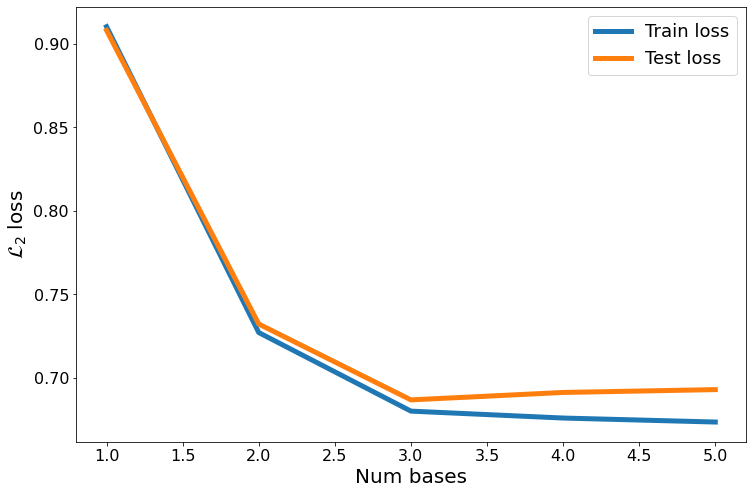

In [54]:
# How does loss improve as we add bases?
plt.figure(figsize=(12,8))
plt.plot(range(1, len(last_losses)+1), [l[0] for l in last_losses], label="Train loss", linewidth=5.0)
plt.plot(range(1, len(last_losses)+1), [l[1] for l in last_losses], label="Test loss", linewidth=5.0)
plt.xlabel("Num bases", fontsize=20)
plt.ylabel("$\mathcal{L}_2$ loss", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=18)
plt.show()

# It looks like we continue to have a monotonic improvement in loss on the training set as we add more
#  bases, but beyond 3 or 4 bases the test set performance begins to suffer. This gives us a natural
#  way to pick the number of bases we will use going forward: monitor performance on a *validation* set
#  as a function of the basis count, and stop adding bases when it begins to negatively impact loss on
#  the validation set.

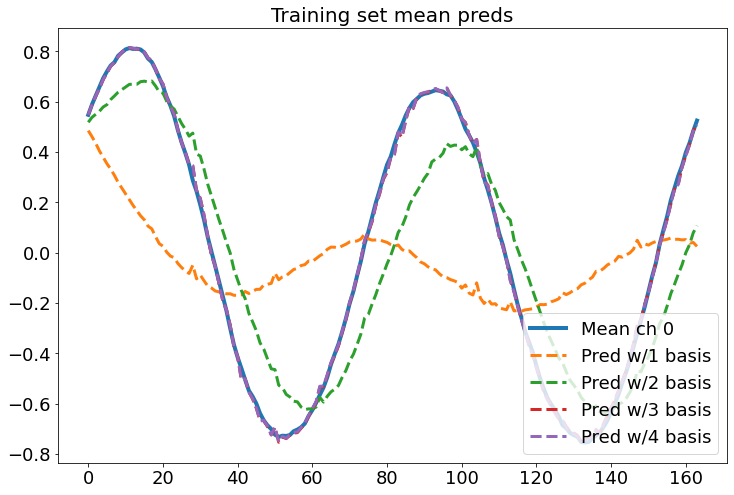

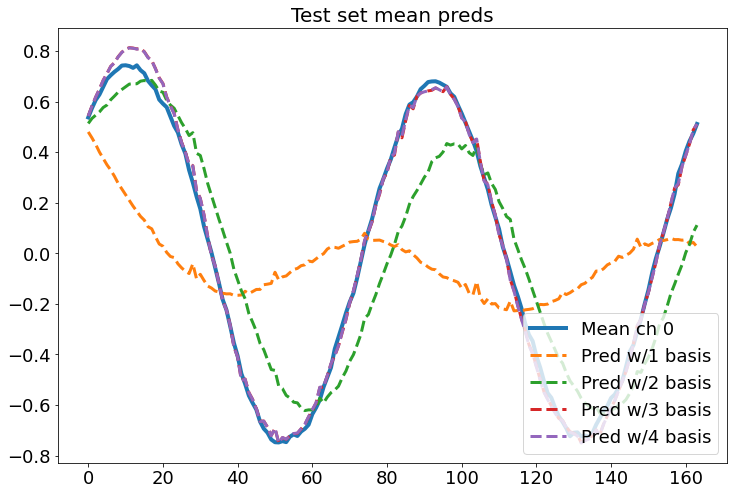

In [57]:
# Let's look at how predictions evolve as we add more bases
y_train_means = torch.mean(y_train, axis=0).detach().cpu()
y_test_means = torch.mean(y_test, axis=0).detach().cpu()

plt.figure(figsize=(12, 8))
plt.plot(y_train_means[:, 0], label="Mean ch 0", linewidth=4.0)
for bidx, yh in enumerate(yhat_train_history):
    yhm = torch.mean(yh.detach().cpu(), axis=0)
    plt.plot(yhm[:, 0], "--", label=f"Pred w/{bidx+1} basis", linewidth=3.0)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Training set mean preds", fontsize=20)
plt.legend(loc="lower right", fontsize=18)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(y_test_means[:, 0], label="Mean ch 0", linewidth=4.0)
for bidx, yh in enumerate(yhat_test_history):
    yhm = torch.mean(yh.detach().cpu(), axis=0)
    plt.plot(yhm[:, 0], "--", label=f"Pred w/{bidx+1} basis", linewidth=3.0)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title("Test set mean preds", fontsize=20)
plt.legend(loc="lower right", fontsize=18)
plt.show()

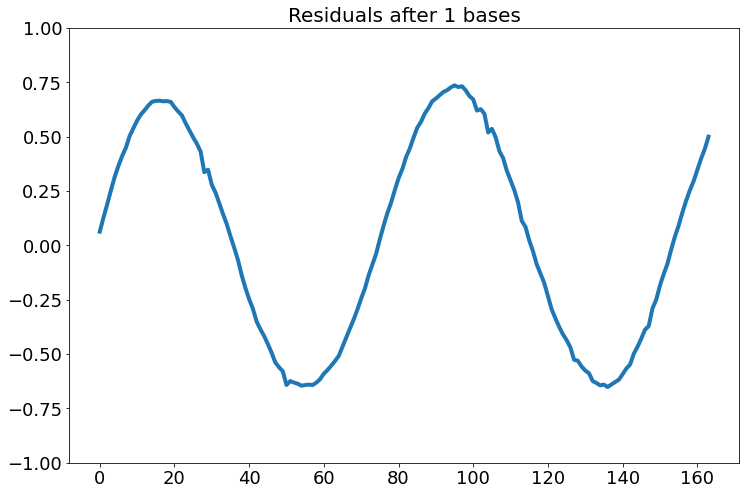

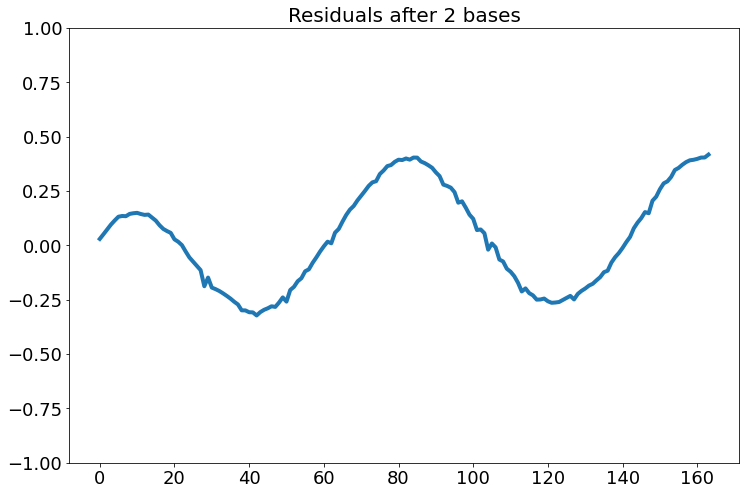

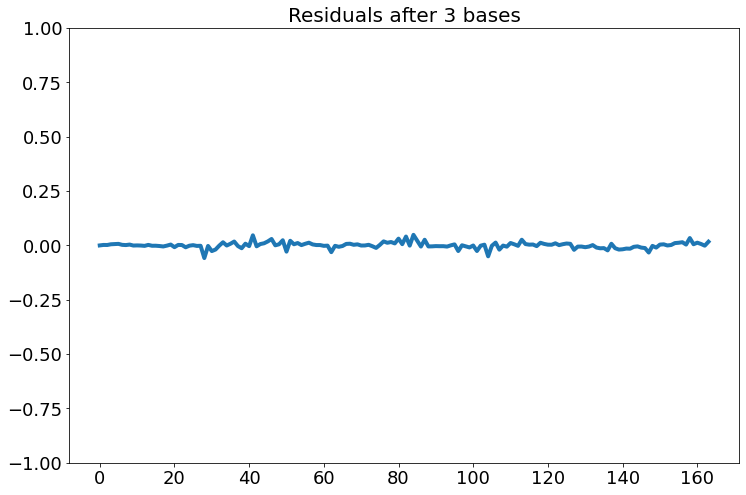

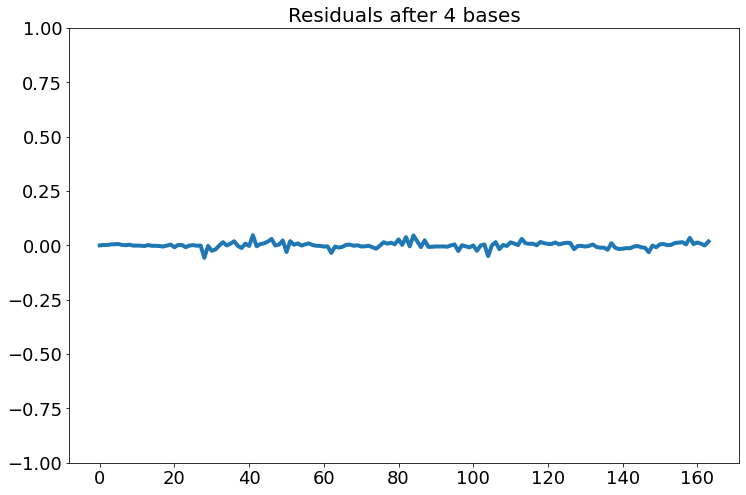

In [58]:
# What do residuals look like?

ytm = y_train_means[:, 0].detach().cpu()
for bidx, yh in enumerate(yhat_train_history):
    plt.figure(figsize=(12, 8))
    yhm = torch.mean(yh.detach().cpu(), axis=0)[:, 0]
    residual = ytm - yhm
    plt.plot(residual, linewidth=4.0)
    plt.title(f"Residuals after {bidx+1} bases", fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim([-1, 1])
    plt.show()